<a href="https://colab.research.google.com/github/DDiekmann/Applied-Verification-Lab-Neural-Networks/blob/main/Tutorials/Tutorial_for_Neural_Network_Verification_with_Marabou.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial for Neural Network Verification with Marabou

---

*As an example we try to verifiy the **robustness** of a classification Network trained on the MNIST dataset and **fairness** of a classification network trained on the census income dataset.
In both verifications we are using [Marabou](https://neuralnetworkverification.github.io/).*

Important Links:
- [Marabou sourcecode](https://github.com/NeuralNetworkVerification/Marabou)
- [Marabou documenation](https://neuralnetworkverification.github.io/Marabou/)

---

As in the other tutorials, the focus of this tutorial we don´t focus on details of the pre processing and training. If you are interested in that part you can look into the training code for this tutorial at our [mnist trainer](https://github.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/blob/main/lib/mnist_trainer.py). Before starting the tutorials we will import required packages and train a model with the mentioned mnist trainer. The model is defined and then used for solving in marabou. Before solving we also need to build and install Marabou. For more details on that you can take a look at the [sourcecode](https://github.com/NeuralNetworkVerification/Marabou) or the [documentation](https://neuralnetworkverification.github.io/Marabou/).

## Prerequisites

Our model will be trained with [pytorch](https://pytorch.org/). We import needed packages and the mnist trainer. To export our trained model and use it with marabou we also import ```torch.onnx```. That´s a format for saving neural networks.

In [ ]:
%%capture 
import torch
from torch import nn
import numpy as np
import torch.onnx
import sys

import matplotlib.pyplot as plt

!wget --no-cache --backups=1 {'https://raw.githubusercontent.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/main/lib/mnist_trainer.py'}

import mnist_trainer

In [ ]:
%pip install onnx onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 7.9 MB/s 
     |████████████████████████████████| 5.2 MB 47.7 MB/s 


## Install Marabou

For installation we followed the instructions of the marabou [documentation](https://neuralnetworkverification.github.io/Marabou/Setup/0_Installation.html).

In [ ]:
!git clone https://github.com/NeuralNetworkVerification/Marabou.git
!cd Marabou && git checkout "492c1b8c703c8a383f421468a104c34710e6d26d"

Cloning into 'Marabou'...
remote: Enumerating objects: 25703, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 25703 (delta 7), reused 5 (delta 0), pack-reused 25686
Receiving objects: 100% (25703/25703), 208.53 MiB | 27.72 MiB/s, done.
Resolving deltas: 100% (18524/18524), done.
Note: checking out '492c1b8c703c8a383f421468a104c34710e6d26d'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 492c1b8c Remove ConstraintBoundTightener (#560)


The following instructions build and install marabou. In Google Colab you use ```%%shell``` to use shell commands in the current cell. 
The build needs about 15 to 20 minutes. 
When building it locally it can depend on available ressources.

In [ ]:
%%shell
cd Marabou
mkdir build
cd build
cmake .. -DBUILD_PYTHON=ON
cmake --build .
cd /content

To finish the installation and use marabou in python we need to add the path to the PYTHONPATH. For that we add the path to ```sys.path```-list in python. Use your prefered method to add it to your PYTHONPATH.

In [ ]:
sys.path.insert(1, '/content/Marabou')

Now everything is prepared to import the api for python.

In [ ]:
from maraboupy import Marabou

In [ ]:
options = Marabou.createOptions(verbosity = 0)

# Verification Of Robustness With Marabou

## Train and export Neural Network

First we define the model. Marabou is a more powerfull tool than z3 and so we can define a more complex neural network as in the [smt-based solver](https://github.com/DDiekmann/Applied-Verification-Lab-Neural-Networks/blob/main/Tutorials/Tutorial%20for%20SMT%20based%20Verification.ipynb).
We define multiple hidden layers and will use way more neurons then in the other tutorial.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, number_of_neurons):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, output_dim),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

To train the defined model, we load the mnist dataset and save a dataloader each for training and testing. With the train-dataset we train the defined model. As seen in the constructor of the neural network the dimensions of neurons are a lot bigger than last time.

In [ ]:
%%capture
train_dataloader, test_dataloader = mnist_trainer.load_mnist_dataset(batch_size=64)

In [ ]:
model = mnist_trainer.train_model(
    NeuralNetwork(input_dim=28*28, output_dim=10, number_of_neurons=20), 
    epochs=3, 
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    )

Epoch 1
-------------------------------


100%|██████████| 938/938 [00:07<00:00, 130.46it/s]


Test Error: 
 Accuracy: 91.0%, Avg loss: 0.306887 

Epoch 2
-------------------------------


100%|██████████| 938/938 [00:07<00:00, 128.36it/s]


Test Error: 
 Accuracy: 92.4%, Avg loss: 0.255010 

Epoch 3
-------------------------------


100%|██████████| 938/938 [00:07<00:00, 130.35it/s]


Test Error: 
 Accuracy: 93.0%, Avg loss: 0.230946 

Done!


Next we export the model as a ```.onnx``` format. Because we need to export another model later again, we define a function to do so. In your code you can also just use the code block in your script without defining a function.

In [3]:
def export_as_onnx(model, model_filename, dummy_input): 
  # set model to eval mode
  model.eval()

  # create a dummy input in the shape of the input values
  device = "cuda" if torch.cuda.is_available() else "cpu"
  dummy_input = dummy_input.to(device)

  torch.onnx.export(model,
                    dummy_input,
                    model_filename,
                    export_params=True,
                    verbose=False,
                    input_names=['image'],
                    output_names=['classification'],
                    )

In [ ]:
model_filename = "mnist_net.onnx"
export_as_onnx(model, model_filename=model_filename, dummy_input=torch.randn(1, 28, 28))

## Verify Robustness With Marabou

With marabou we read the exported model. 

In [ ]:
network = Marabou.read_onnx(model_filename)

inputVars = network.inputVars[0][0]
outputVars = network.outputVars[0][0]

Using marabou we predict the class of our example image. 
For verification we will use that example. For now we evaluate the number of the mnist test image. 
For visualisation we show the image and the correct and predicted class.

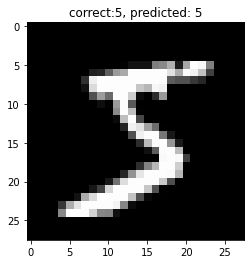

In [ ]:
inputs, classes = next(iter(train_dataloader))
image = inputs[0].numpy()[0]
correct_class = classes[0].item()

network_ouput = network.evaluateWithoutMarabou([image])[0]
predicted_class = np.argmax(network_ouput)

plt.title(f"correct:{correct_class}, predicted: {predicted_class}")
plt.imshow(image.reshape(28,28), cmap='gray')

As in the last tutorial our goal is to find a pertubation so that the model fails to identify the correct class. For that we define an epsilon. 

In [ ]:
epsilon = 0.1

We define bounds for every pixel so that the value is the old value +/- epsilon.

In [ ]:
for h in range(inputVars.shape[0]):
  for w in range(inputVars.shape[1]):
    network.setLowerBound(inputVars[h][w], image[h][w] - epsilon)
    network.setUpperBound(inputVars[h][w], image[h][w] + epsilon)

With marabou we solve the network with defined constraints.

In [ ]:
for i in range(outputVars.shape[0]):
  if i != correct_class:
    # add max constraint
    network.addMaxConstraint(set(outputVars), outputVars[i])
    # solve
    exit_code, vals, stats = network.solve(verbose = False, options = options)
    # if solution found, break
    print(exit_code)
    if len(vals) > 0:
      break

sat


## Visualise Adversarial Example

To show the adversarial example we extract the new input data and save that in an numpy array.
Next we extract the new class that the neural network predicts

In [ ]:
adversarial_image = [[] for _ in range(inputVars.shape[1])]
for h in range(inputVars.shape[0]):
  for w in range(inputVars.shape[1]):
    adversarial_image[h].insert(w, vals[inputVars[h][w]])
adversarial_image = np.array(adversarial_image)

outputs = []
for h in range(outputVars.shape[0]):
  outputs.insert(h, vals[outputVars[h]])
print(outputs)
print(np.argmax(outputs))

[-2.094623769819583, -2.094623769819583, -3.4436123316690326, -2.094623769819583, -7.328257865187606, -2.094623769819583, -4.198666076957091, -2.425855902306662, -2.57220759021058, -2.094623769819583]
0


Now we can see the slightly changed image. The model should not predict the correct number.

3


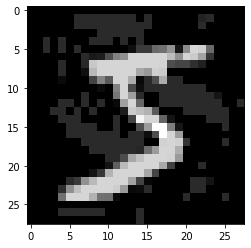

In [ ]:
network_ouput = network.evaluateWithoutMarabou([adversarial_image])[0]
predicted_class = np.argmax(network_ouput)

plt.title(f"correct:{correct_class}, predicted: {predicted_class}")
plt.imshow(adversarial_image, cmap='gray')

All the work we have done is included in the marabou implementation. 
Marabou evaluates the robustness with a given epsilon.

In [ ]:
epsilon = 0.05

network = Marabou.read_onnx(model_filename)
network.evaluateLocalRobustness(image, epsilon, correct_class, options=options)

unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat
unsat


[{}, <maraboupy.MarabouCore.Statistics at 0x7f91f245c8b0>, None]

# Verification Of Fairness With Marabou

As mentioned in this subsection we guide you through the verification of the fairness property with marabou. For that we will train a network on another dataset and then verify the fairness with marabou as we did with robustness.

## Training And Exporting The Neural Network


We train the neural network on the [Census Income Data Set](https://archive.ics.uci.edu/ml/datasets/census+income). 
This classification problem has a set of inputs like age, gender, workclass and other. 
The classifier now has to predict whether the income is above or below $50.000.

---

### Listing of input features (encoded with integers starting with 1):

* age: continuous.

* workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.

* fnlwgt: continuous.

* education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.

* education-num: continuous.

* marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.

* occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.

* relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.

* race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.

* sex: Female, Male.

* capital-gain: continuous.

* capital-loss: continuous.

* hours-per-week: continuous.

* native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

### Output (encoded with two neurons): 
* <=50K or >50K

In [ ]:
%%capture
census_train_dataloader, census_test_dataloader = mnist_trainer.load_census_income_dataset(batch_size=64)

In [ ]:
# train model
census_model = mnist_trainer.train_model(
    NeuralNetwork(input_dim=14, output_dim=2, number_of_neurons=20), 
    epochs=5, 
    train_dataloader=census_train_dataloader,    
    test_dataloader=census_test_dataloader,
    )

# export model
census_model_filename = "census_net.onnx"
export_as_onnx(census_model, model_filename=census_model_filename, dummy_input=torch.randn(1, 14))

## Verify Fairness With Marabou


As before we need to read the network with marabou again.

In [ ]:
census_network = Marabou.read_onnx(census_model_filename)

inputVars = census_network.inputVars[0][0]
outputVars = census_network.outputVars[0][0]

The fairness property states

In [ ]:
# TODO



exit_code, vals, stats = network.solve(verbose = False, options = options)